In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sentence_transformers import SentenceTransformer, models
from scipy.spatial.distance import cosine
import seaborn as sns
from itertools import combinations
from collections import Counter

In [37]:
# Load the dataset
session_data = pd.read_csv('session_data.csv')

In [38]:
# Display the first few rows of the dataset
print(session_data.head())

# Check the data types and missing values
print(session_data.info())
print(session_data.isnull().sum())

                         session_id          product_name
0  000ed966131fcb96e0efc4ff2b716a3e              beetroot
1  000ed966131fcb96e0efc4ff2b716a3e              cucumber
2  0013eab657eaf2d82d7f1e13023d95c2                 onion
3  0013eab657eaf2d82d7f1e13023d95c2  long shelf life milk
4  0013fabde1e543dd541be925266aadbc                 dates
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345152 entries, 0 to 345151
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    345152 non-null  object
 1   product_name  345152 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB
None
session_id      0
product_name    0
dtype: int64


In [39]:
# Number of unique sessions and products
num_sessions = session_data['session_id'].nunique()
num_products = session_data['product_name'].nunique()
print(f"Number of unique sessions: {num_sessions}")
print(f"Number of unique products: {num_products}")

# Distribution of products per session
products_per_session = session_data.groupby('session_id').size()
print(products_per_session.describe())

# Distribution of sessions per product
sessions_per_product = session_data.groupby('product_name').size()
print(sessions_per_product.describe())

# Most and least frequent products
most_frequent_products = sessions_per_product.sort_values(ascending=False).head(10)
least_frequent_products = sessions_per_product.sort_values(ascending=True).head(10)
print("Most frequent products:")
print(most_frequent_products)
print("Least frequent products:")
print(least_frequent_products)


Number of unique sessions: 165335
Number of unique products: 396
count    165335.000000
mean          2.087592
std           0.323845
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           9.000000
dtype: float64
count      396.000000
mean       871.595960
std       2730.275337
min          1.000000
25%         44.000000
50%        151.500000
75%        540.250000
max      31196.000000
dtype: float64
Most frequent products:
product_name
onion                   31196
cucumber                19083
fresh cow milk          18086
beetroot                17077
gourds                  15625
curd                    15578
long shelf life milk    10336
garlic                   9222
tender coconut           9155
detergent powder         8414
dtype: int64
Least frequent products:
product_name
shringar            1
food wrapping       1
coriander leaves    1
plant based         1
cola drinks         1
holi needs          1
suitcase            1
ice

In [40]:
# Average number of products per session
average_products_per_session = products_per_session.mean()
print(f"Average number of products per session: {average_products_per_session:.2f}")

# Sessions with the most and least number of products
most_products_session = products_per_session.idxmax()
least_products_session = products_per_session.idxmin()
print(f"Session with the most products: {most_products_session}")
print(f"Session with the least products: {least_products_session}")


Average number of products per session: 2.09
Session with the most products: 27d86d946e6ea6d022f12211d61f8ac7
Session with the least products: 0000bc46bf70d6ebb01c8b58f5e619ab


In [41]:
# Most popular products
popular_products = session_data['product_name'].value_counts().head(10)
print("Most popular products:")
print(popular_products)

# Create a list of product lists for each session
product_lists = session_data.groupby('session_id')['product_name'].apply(list)

# Count co-occurrences
co_occurrences = Counter()
for product_list in product_lists:
    for combo in combinations(product_list, 2):
        co_occurrences[tuple(sorted(combo))] += 1

# Most common co-occurrences
most_common_co_occurrences = co_occurrences.most_common(10)
print("Most common product co-occurrences:")
print(most_common_co_occurrences)


Most popular products:
product_name
onion                   31196
cucumber                19083
fresh cow milk          18086
beetroot                17077
gourds                  15625
curd                    15578
long shelf life milk    10336
garlic                   9222
tender coconut           9155
detergent powder         8414
Name: count, dtype: int64
Most common product co-occurrences:
[(('beetroot', 'cucumber'), 8595), (('long shelf life milk', 'onion'), 5067), (('curd', 'fresh cow milk'), 4408), (('onion', 'tender coconut'), 3618), (('beetroot', 'gourds'), 3419), (('cucumber', 'gourds'), 3198), (('baby fruits', 'onion'), 2540), (('fresh cow milk', 'onion'), 2363), (('fresh beans', 'gourds'), 2027), (('beetroot', 'fresh beans'), 1926)]


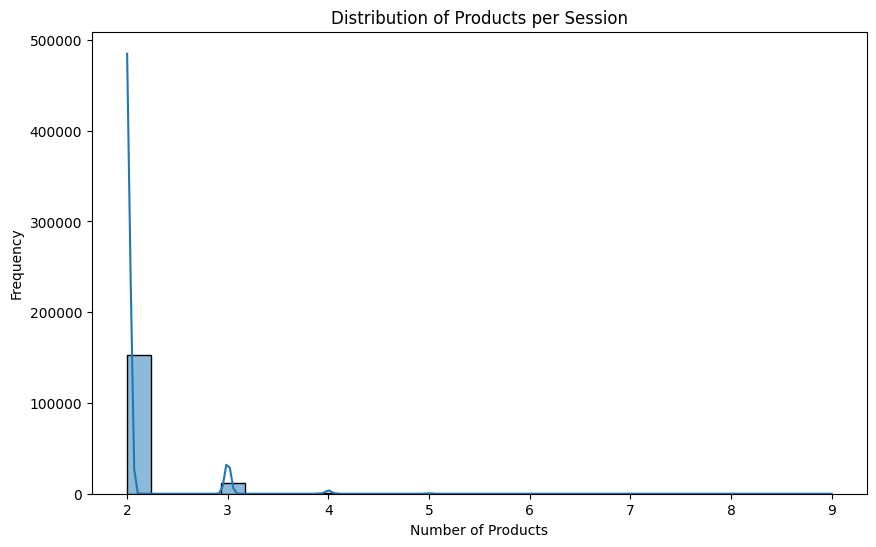

In [42]:
import seaborn as sns
# Distribution of products per session
products_per_session = session_data.groupby('session_id').size()

plt.figure(figsize=(10, 6))
sns.histplot(products_per_session, bins=30, kde=True)
plt.title('Distribution of Products per Session')
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.show()


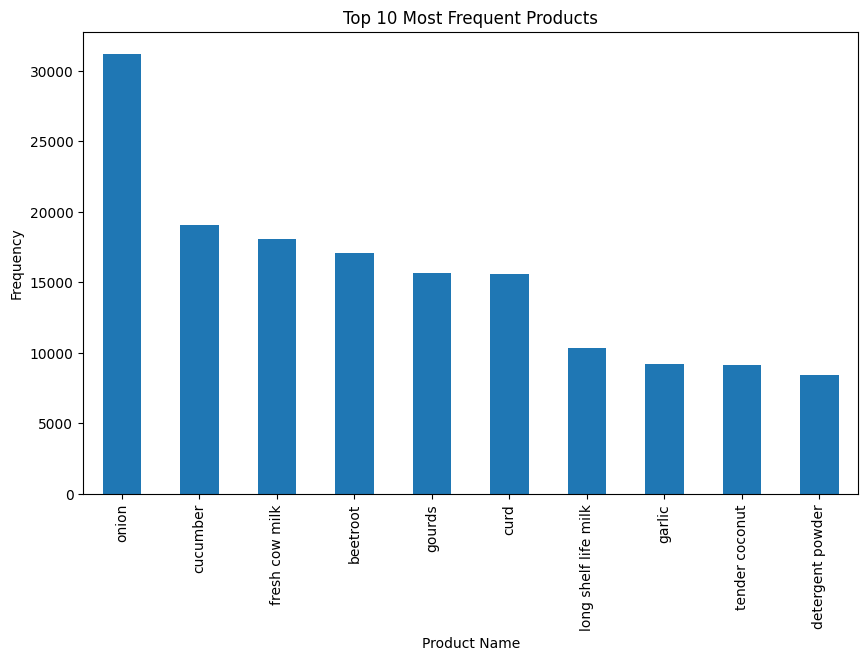

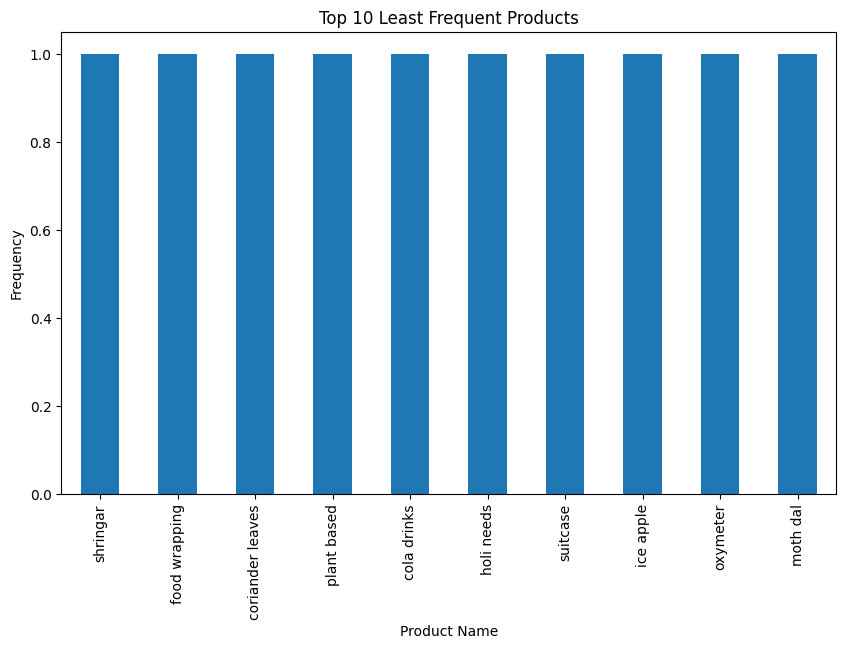

In [43]:
# Distribution of sessions per product
sessions_per_product = session_data.groupby('product_name').size()

# Most frequent products
most_frequent_products = sessions_per_product.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
most_frequent_products.plot(kind='bar')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.show()

# Least frequent products
least_frequent_products = sessions_per_product.sort_values(ascending=True).head(10)

plt.figure(figsize=(10, 6))
least_frequent_products.plot(kind='bar')
plt.title('Top 10 Least Frequent Products')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.show()


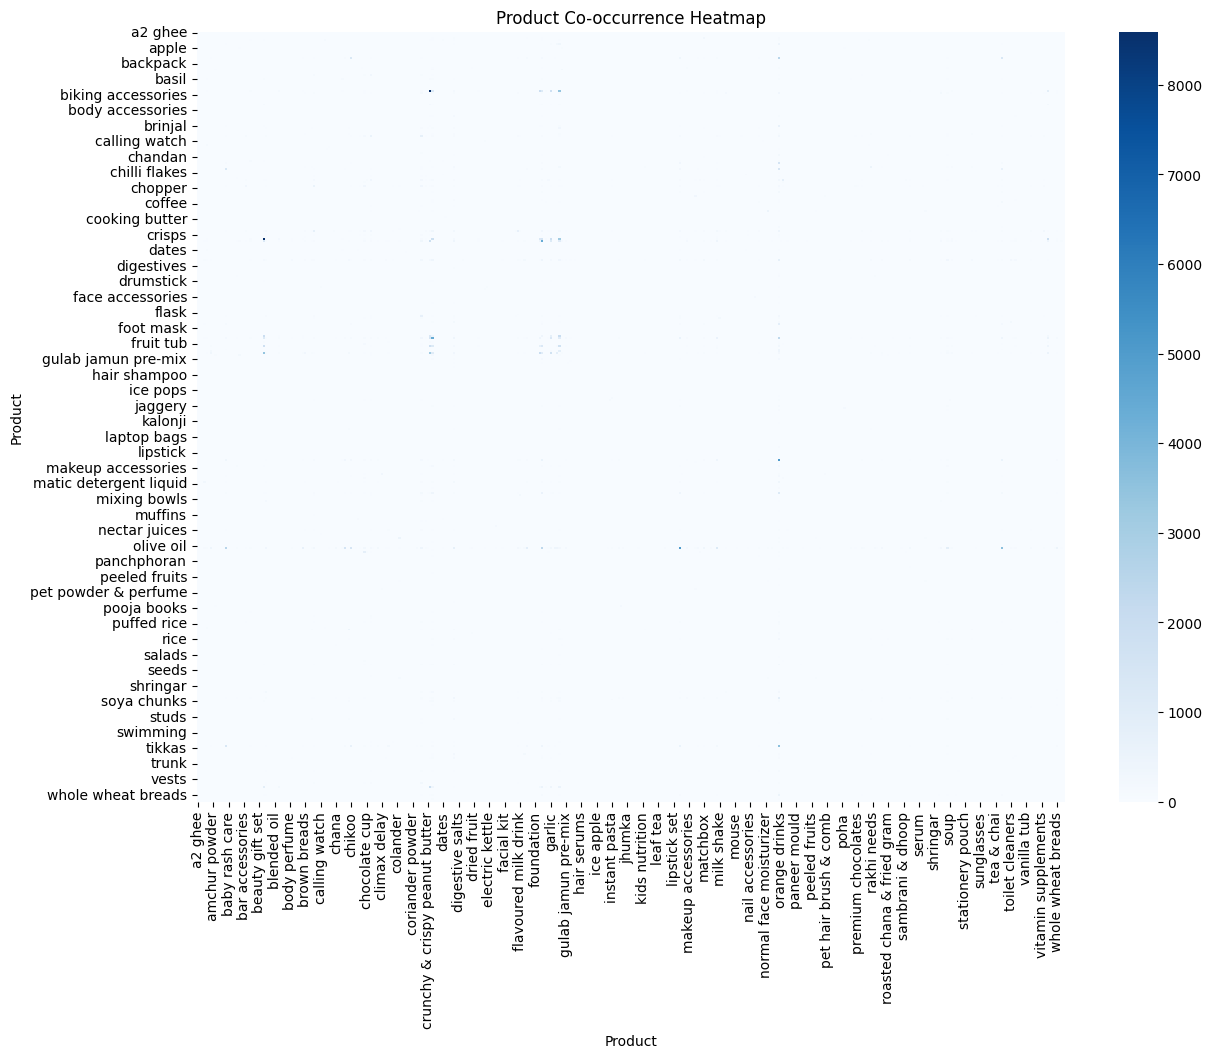

In [44]:
# Create a list of product lists for each session
product_lists = session_data.groupby('session_id')['product_name'].apply(list)

# Count co-occurrences
co_occurrences = Counter()
for product_list in product_lists:
    for combo in combinations(product_list, 2):
        co_occurrences[tuple(sorted(combo))] += 1

# Convert co-occurrences to a DataFrame
co_occurrence_matrix = pd.DataFrame(
    index=sessions_per_product.index,
    columns=sessions_per_product.index
).fillna(0)

for (product1, product2), count in co_occurrences.items():
    co_occurrence_matrix.loc[product1, product2] = count
    co_occurrence_matrix.loc[product2, product1] = count

plt.figure(figsize=(14, 10))
sns.heatmap(co_occurrence_matrix, cmap='Blues')
plt.title('Product Co-occurrence Heatmap')
plt.xlabel('Product')
plt.ylabel('Product')
plt.show()


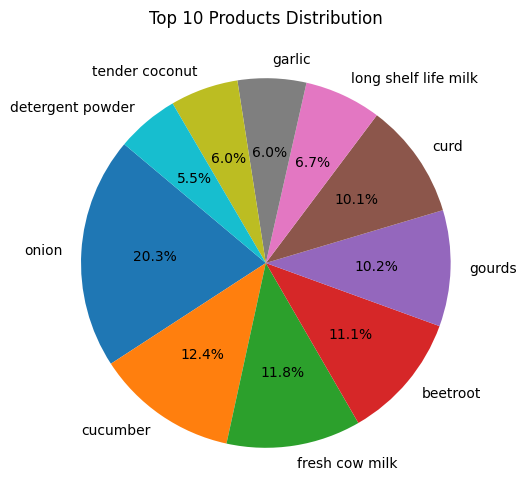

In [45]:
# Pie chart for product distribution
product_distribution = sessions_per_product.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
product_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Products Distribution')
plt.ylabel('')
plt.show()


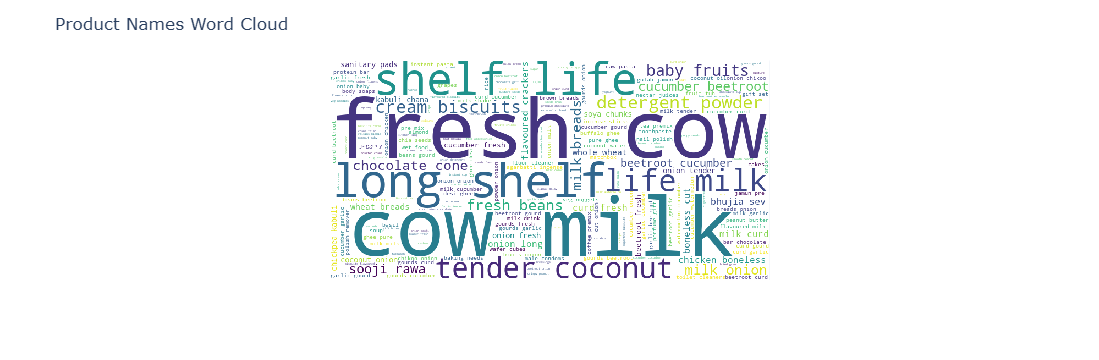

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# Create a string with all product names
text = ' '.join(session_data['product_name'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Convert wordcloud image to a format Plotly can handle
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png', format='png')
plt.close()

# Load the image with Plotly
img = px.imshow(np.array(wordcloud))
img.update_layout(
    title='Product Names Word Cloud',
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(showgrid=False, showticklabels=False),
    yaxis=dict(showgrid=False, showticklabels=False)
)

# Show the interactive word cloud
img.show()


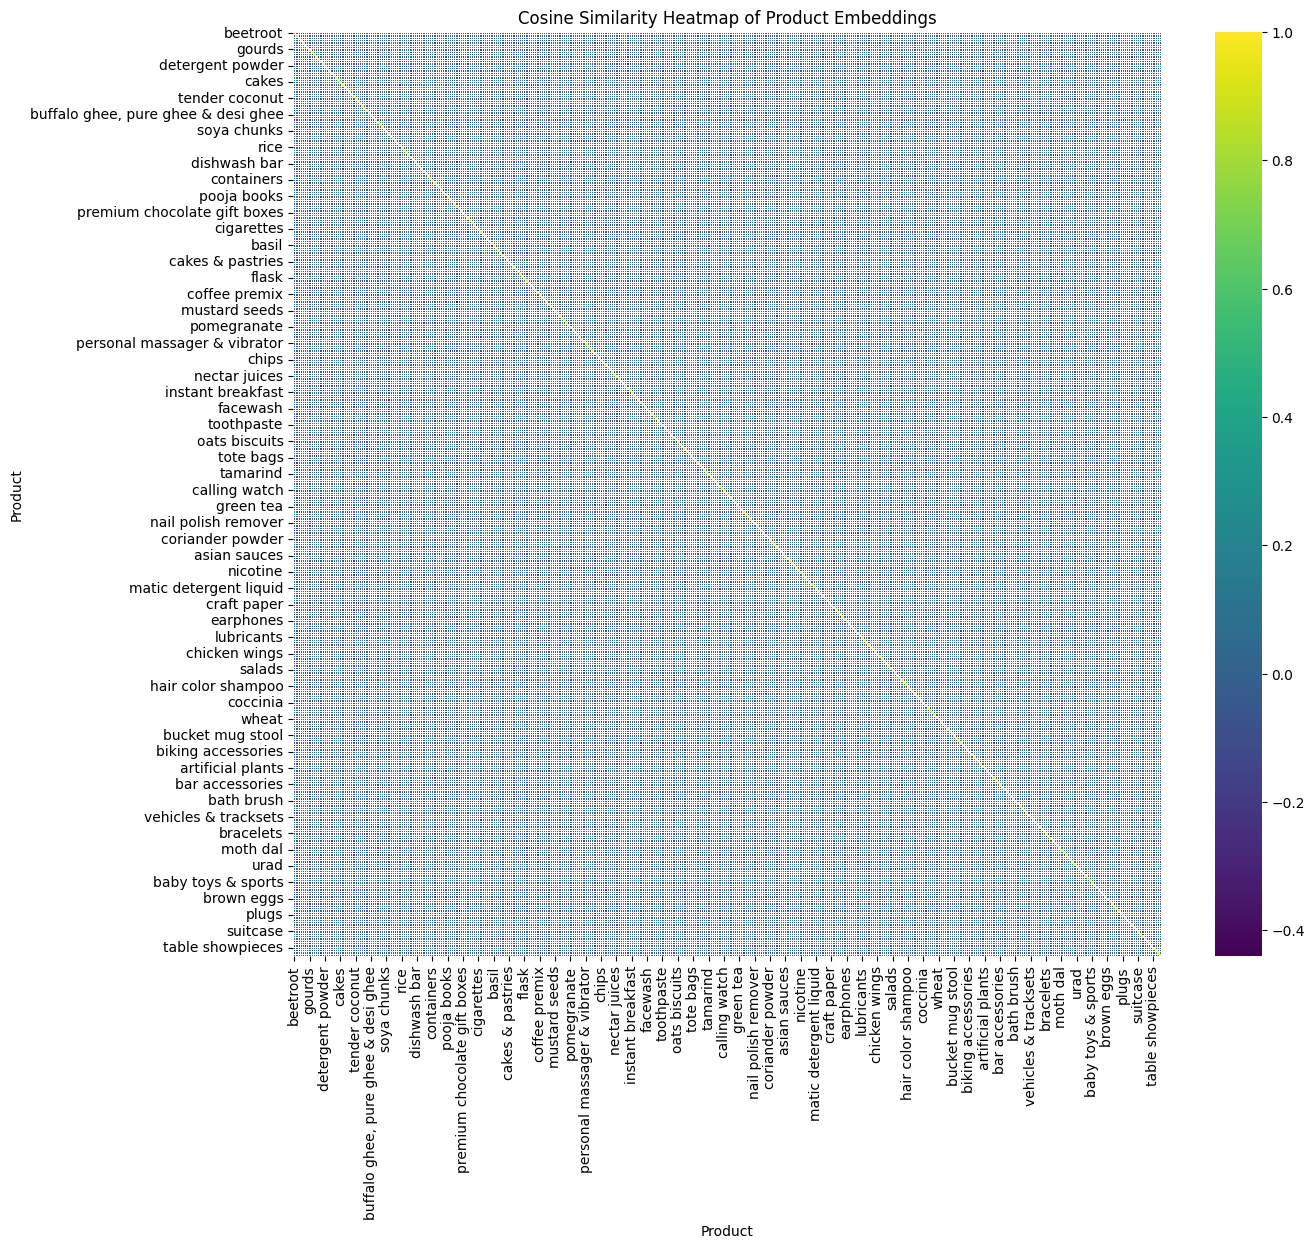

In [47]:
# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cosine_sim_df, cmap='viridis', annot=False, fmt=".2f", linewidths=0.5)

# Update plot titles and labels
plt.title('Cosine Similarity Heatmap of Product Embeddings')
plt.xlabel('Product')
plt.ylabel('Product')

# Show the plot
plt.show()


In [48]:
# Add Quantity column and pivot the data
session_data["Quantity"] = 1
dataWide = session_data.pivot(index="session_id", columns="product_name", values="Quantity")
dataWide.fillna(0, inplace=True)

# Prepare data for item-based similarity calculations
data_ib = dataWide.copy()
data_ib = data_ib.reset_index()
data_ib = data_ib.drop("session_id", axis=1)

# Initialize similarity dataframe for item-based similarities
data_ibs = pd.DataFrame(index=data_ib.columns, columns=data_ib.columns)

In [49]:
# Calculate cosine similarities between products for item-based recommendations
for i in range(len(data_ibs.columns)):
    for j in range(len(data_ibs.columns)):
        if i != j:
            data_ibs.iloc[i, j] = 1 - cosine(data_ib.iloc[:, i], data_ib.iloc[:, j])
        else:
            data_ibs.iloc[i, j] = 0

In [50]:
# Ensure product names are in a list of lists format suitable for TF-IDF
product_names = session_data['product_name'].unique().tolist()
sentences = [[product] for product in product_names]

In [51]:
# Assume session_data['product_name'] contains the product names
product_names = session_data['product_name'].unique().tolist()

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the product names to get TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(product_names)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert similarity matrix to DataFrame
weighted_sim_df = pd.DataFrame(similarity_matrix, index=product_names, columns=product_names)

# Example output
print(weighted_sim_df.head())


                      beetroot  cucumber  onion  long shelf life milk  dates  \
beetroot                   1.0       0.0    0.0                   0.0    0.0   
cucumber                   0.0       1.0    0.0                   0.0    0.0   
onion                      0.0       0.0    1.0                   0.0    0.0   
long shelf life milk       0.0       0.0    0.0                   1.0    0.0   
dates                      0.0       0.0    0.0                   0.0    1.0   

                      matchbox  brinjal  gourds  notebook  rain accessories  \
beetroot                   0.0      0.0     0.0       0.0               0.0   
cucumber                   0.0      0.0     0.0       0.0               0.0   
onion                      0.0      0.0     0.0       0.0               0.0   
long shelf life milk       0.0      0.0     0.0       0.0               0.0   
dates                      0.0      0.0     0.0       0.0               0.0   

                      ...  shringar  holi ne

In [ ]:
# Training the BERT Model
# Assuming you have a dataset of product names with a dummy label for fine-tuning
product_names = session_data['product_name'].unique().tolist()
labels = [0] * len(product_names)  # Dummy labels

# Prepare the dataset
data = {'text': product_names, 'label': labels}
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the input
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('fine_tuned_bert')


In [52]:
# Define the BERT model and mean pooling for SentenceTransformers
word_embedding_model = models.Transformer('fine_tuned_bert')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

# Load the model
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Generate embeddings for all product names
product_embeddings = model.encode(product_names, convert_to_tensor=True)

# Convert embeddings to a DataFrame for easy manipulation
product_embeddings_df = pd.DataFrame(product_embeddings.cpu().numpy(), index=product_names)

# Compute cosine similarity
bert_sim = cosine_similarity(product_embeddings_df)
bert_sim_df = pd.DataFrame(bert_sim, index=product_names, columns=product_names)


In [57]:
# Ensemble Recommendation System
def ensemble_recommendation(cart_products, tfidf_sim_df, bert_sim_df, ibs_sim_df, weight_tfidf=0.4, weight_bert=0.4, weight_ibs=0.2, top_n=10):
    combined_scores = pd.Series(0, index=tfidf_sim_df.columns)
    
    for product in cart_products:
        if product in tfidf_sim_df.columns:
            top_similar_products_tfidf = tfidf_sim_df[product].sort_values(ascending=False).index[1:top_n+1]
            for similar_product in top_similar_products_tfidf:
                if similar_product not in cart_products:
                    combined_scores[similar_product] += weight_tfidf * tfidf_sim_df[product][similar_product]

        if product in bert_sim_df.columns:
            top_similar_products_bert = bert_sim_df[product].sort_values(ascending=False).index[1:top_n+1]
            for similar_product in top_similar_products_bert:
                if similar_product not in cart_products:
                    combined_scores[similar_product] += weight_bert * bert_sim_df[product][similar_product]

        if product in ibs_sim_df.columns:
            top_similar_products_ibs = ibs_sim_df[product].sort_values(ascending=False).index[1:top_n+1]
            for similar_product in top_similar_products_ibs:
                if similar_product not in cart_products:
                    combined_scores[similar_product] += weight_ibs * ibs_sim_df[product][similar_product]

    # Exclude products in the cart from recommendations
    combined_scores = combined_scores.drop(cart_products, errors='ignore')
    
    # Find the product with the highest combined score
    recommended_product = combined_scores.sort_values(ascending=False).index[0]
    return recommended_product


In [58]:
# Example usage
cart_products = ['almond', 'cashew']  # Example products in the cart
recommendation = ensemble_recommendation(cart_products, tfidf_sim_df, bert_sim_df, data_ibs)
print("Recommended product:", recommendation)

Recommended product: almond milk
